<a href="https://colab.research.google.com/github/chenzenan97/studious-adventure/blob/main/Chen_AIPI590_Assign2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN and Double DQN with Stable-Baselines3

Stable-Baselines3: https://github.com/DLR-RM/stable-baselines3

Documentation: https://stable-baselines.readthedocs.io/en/master/

RL Baselines3 zoo: https://github.com/DLR-RM/rl-baselines3-zoo

Double Q-Learning: https://paperswithcode.com/method/double-q-learning


[RL Baselines3 Zoo](https://github.com/DLR-RM/rl-baselines3-zoo) is a collection of pre-trained Reinforcement Learning agents using Stable-Baselines3.

It also provides basic scripts for training, evaluating agents, tuning hyperparameters and recording videos.


## Introduction

In this notebook, we will study DQN using Stable-Baselines3 and then see how to reduce value overestimation with double DQN.

## Installation

We will install master version of SB3.

In [ ]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization

!pip install git+https://github.com/DLR-RM/stable-baselines3#egg=stable-baselines3[extra]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DLR-RM/stable-baselines3 to /tmp/pip-install-g0kv8c5j/stable-baselines3_c804e133055c46fbb367b4dd2fe67a6b
  Running command git clone -q https://github.com/DLR-RM/stable-baselines3 /tmp/pip-install-g0kv8c5j/stable-baselines3_c804e133055c46fbb367b4dd2fe67a6b


Import DQN and evaluation helper

In [ ]:
import gym
import numpy as np
import torch as th
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

## The Mountain Car Problem

In this environment, the agent must drive an underpowered car up a steep mountain road. For any given state the agent may choose to accelerate to the left, right or cease any acceleration.

Source: https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

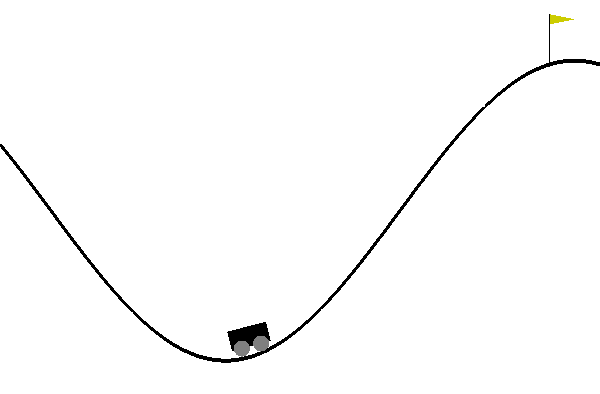


    Observation:
        Type: Box(2)
        Num    Observation               Min            Max
        0      Car Position              -1.2           0.6
        1      Car Velocity              -0.07          0.07
    Actions:
        Type: Discrete(3)
        Num    Action
        0      Accelerate to the Left
        1      Don't accelerate
        2      Accelerate to the Right
        Note: This does not affect the amount of velocity affected by the
        gravitational pull acting on the car.
    Reward:
         Reward of 0 is awarded if the agent reached the flag (position = 0.5)
         on top of the mountain.
         Reward of -1 is awarded if the position of the agent is less than 0.5.
    Starting State:
         The position of the car is assigned a uniform random value in
         [-0.6 , -0.4].
         The starting velocity of the car is always assigned to 0.
    Episode Termination:
         The car position is more than 0.5
         Episode length is greater than 200



Create the environment

In [ ]:
env = gym.make("MountainCar-v0")

Create the model with tuned hyperparameters from the RL Zoo

```yaml
MountainCar-v0:
  n_timesteps: !!float 1.2e5
  policy: 'MlpPolicy'
  learning_rate: !!float 4e-3
  batch_size: 128
  buffer_size: 10000
  learning_starts: 1000
  gamma: 0.98
  target_update_interval: 600
  train_freq: 16
  gradient_steps: 8
  exploration_fraction: 0.2
  exploration_final_eps: 0.07
  policy_kwargs: "dict(net_arch=[256, 256])"
```

In [ ]:
tensorboard_log = "data/tb/"

In [ ]:
dqn_model = DQN("MlpPolicy",
            env,
            verbose=1,
            train_freq=16,
            gradient_steps=8,
            gamma=0.99,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=600,
            learning_starts=1000,
            buffer_size=10000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            tensorboard_log=tensorboard_log,
            seed=2)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Evaluate the agent before training

In [ ]:
mean_reward, std_reward = evaluate_policy(dqn_model, dqn_model.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-200.00 +/- 0.00


In [ ]:
# Optional: Monitor training in tensorboard
# %load_ext tensorboard
# %tensorboard --logdir $tensorboard_log

We will first train the agent until convergence and then analyse the learned q-value function.

In [ ]:
dqn_model.learn(int(1.2e5), log_interval=10)

Logging to data/tb/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 829      |
|    time_elapsed     | 2        |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 3.35e-05 |
|    n_updates        | 496      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 488      |
|    time_elapsed     | 8        |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 1.39e-

Evaluate after training, the mean episodic reward should have improved.

In [ ]:
mean_reward, std_reward = evaluate_policy(dqn_model, dqn_model.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-141.65 +/- 48.05


### Prepare video recording

In [ ]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

We will record a video using the [VecVideoRecorder](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#vecvideorecorder) wrapper, you will learn about those wrapper in the next notebook.

In [ ]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(env_id)])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs, deterministic=False)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

## Visualize trained agent

In [ ]:
record_video('MountainCar-v0', dqn_model, video_length=500, prefix='dqn-mountaincar')

Saving video to /content/videos/dqn-mountaincar-step-0-to-step-500.mp4


In [ ]:
show_videos('videos', prefix='dqn')

## Exercise (30 minutes): Double DQN

In DQN, the same network is responsible for selecting and estimating the best next action (in the TD-target) and that may lead to over-estimation (the action which q-value is over-estimated will be chosen more often and this slow down training).

To reduce over-estimation, double q-learning (and then double DQN) was proposed. It decouples the action selection from the value estimation.

Concretely, in DQN, the target q-value is defined as:

$$Y^{DQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1}, a; \mathbb{\theta}_{target}\right); \mathbb{\theta}_{target}\right)$$

where the target network `q_net_target` with parameters $\mathbb{\theta}_{target}$ is used for both action selection and estimation, and can therefore be rewritten:

$$Y^{DQN}_{t} = r_{t+1} + \gamma \max_{a}{Q}\left(s_{t+1}, a; \mathbb{\theta}_{target}\right)$$

Double DQN uses the online network `q_net` with parameters $\mathbb{\theta}_{online}$ to select the action and the target network `q_net_target` to estimate the associated q-values:

$$Y^{DoubleDQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1}, a; \mathbb{\theta}_{online}\right); \mathbb{\theta}_{target}\right)$$


The goal in this exercise is for you to write the update method for `DoubleDQN`.

You will need to:

1. Sample replay buffer data using `self.replay_buffer.sample(batch_size)`

2. Compute the Double DQN target q-value using the next observations `replay_data.next_observation`, the online network `self.q_net`, the target network `self.q_net_target`, the rewards `replay_data.rewards` and the termination signals `replay_data.dones`. Be careful with the shape of each object ;)

3. Compute the current q-value estimates using the online network `self.q_net`, the current observations `replay_data.observations` and the buffer actions `replay_data.actions`

4. Compute the loss to train the q-network using L2 or Huber loss (`F.smooth_l1_loss`)


Link: https://paperswithcode.com/method/double-q-learning

Paper: https://arxiv.org/abs/1509.06461



In [ ]:
from torch.nn import functional as F

class DoubleDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            ### YOUR CODE HERE
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)

            # Do not backpropagate gradient to the target network
            with th.no_grad():
#                 print(f"replay data actions: {replay_data.actions.shape} and data: {replay_data.actions}")
                # Compute the next Q-values using the target network
                next_q_values = self.q_net_target(replay_data.next_observations)
#                 print(f"Next Q values shape calculated by target net: {next_q_values.shape}")
                # Decouple action selection from value estimation
                # Compute q-values for the next observation using the online q net
                next_q_values_online = self.q_net(replay_data.next_observations)
#                 print(f"Next Q values shape calculated by Online net: {next_q_values_online.shape}")
                # Select action with online network
                next_actions_online = next_q_values_online.argmax(dim=1)
#                 print(f"Next Actions shape calculated by Online net: {next_actions_online.shape}")
                # Estimate the q-values for the selected actions using target q network
                next_q_values = th.gather(next_q_values, dim=1, index=next_actions_online.unsqueeze(-1))
#                 print(f"Next Q values calculated by Target net from the selected actions: {next_q_values.shape}")
              
                # 1-step TD target
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)

            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long())

            # Check the shape
            assert current_q_values.shape == target_q_values.shape

            # Compute loss (L2 or Huber loss)
            loss = F.smooth_l1_loss(current_q_values, target_q_values)

            ### END OF YOUR CODE
            
            losses.append(loss.item())

            # Optimize the q-network
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))

## Monitoring Evolution of the Estimated q-value


Here we create a SB3 callback to over-estimate initial q-values and then monitor their evolution over time.

In [ ]:
from torch.nn import functional as F

from stable_baselines3.common.callbacks import BaseCallback


class MonitorQValueCallback(BaseCallback):
    """
    Callback to monitor the evolution of the q-value
    for the initial state.
    It allows to artificially over-estimate a q-value for initial states.

    """
    def __init__(self, sample_interval: int = 2500):
        super().__init__()
        self.timesteps = []
        self.max_q_values = []
        self.sample_interval = sample_interval
        n_samples = 512
        env = gym.make("MountainCar-v0")
        # Sample initial states that will be used to monitor the estimated q-value
        self.start_obs = np.array([env.reset() for _ in range(n_samples)])
    
    def _on_training_start(self) -> None:
        # Create overestimation
        obs = th.tensor(self.start_obs, device=self.model.device).float()
        # Over-estimate going left q-value for the initial states
        target_q_values = th.ones((len(obs), 1), device=self.model.device).float() * 100

        for _ in range(100):
            # Get current Q-values estimates
            current_q_values = self.model.q_net(obs)

            # Over-estimate going left
            current_q_values = th.gather(current_q_values, dim=1, index=th.zeros((len(obs), 1), device=self.model.device).long())

            loss = F.mse_loss(current_q_values, target_q_values)

            # Optimize the policy
            self.model.policy.optimizer.zero_grad()
            loss.backward()
            self.model.policy.optimizer.step()

    def _on_step(self) -> bool:
        # Sample q-values
        if self.n_calls % self.sample_interval == 0:
            # Monitor estimated q-values using current model
            obs = th.tensor(self.start_obs, device=self.model.device).float()
            with th.no_grad():
                q_values = self.model.q_net(obs).cpu().numpy()

            self.logger.record("train/max_q_value", float(q_values.max()))
            self.timesteps.append(self.num_timesteps)
            self.max_q_values.append(q_values.max())
        return True

## Evolution of the q-value with initial over-estimation

### DQN

In [ ]:
dqn_model = DQN("MlpPolicy",
            "MountainCar-v0",
            verbose=1,
            train_freq=16,
            gradient_steps=8,
            gamma=0.99,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=5000,
            learning_starts=1000,
            buffer_size=25000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            tensorboard_log=tensorboard_log,
            seed=102)

Using cuda device
Creating environment from the given name 'MountainCar-v0'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Define the callback

In [ ]:
monitor_dqn_value_cb = MonitorQValueCallback()

In [ ]:
dqn_model.learn(total_timesteps=int(4e4), callback=monitor_dqn_value_cb)

Logging to data/tb/DQN_3
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2914     |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.814    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1260     |
|    time_elapsed     | 1        |
|    total_timesteps  | 1600     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 0.000357 |
|    n_updates        | 296      |
----------------------------------
----------------------------------
| rollout/            |       

### Double DQN

In [ ]:
double_q = DoubleDQN("MlpPolicy",
            "MountainCar-v0",
            verbose=1,
            train_freq=16,
            gradient_steps=8,
            gamma=0.99,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=5000,
            learning_starts=1000,
            buffer_size=25000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            tensorboard_log=tensorboard_log,
            seed=102)

Using cuda device
Creating environment from the given name 'MountainCar-v0'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
monitor_double_q_value_cb = MonitorQValueCallback()

In [ ]:
double_q.learn(int(4e4), log_interval=10, callback=monitor_double_q_value_cb)

Logging to data/tb/DQN_4
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.767    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 997      |
|    time_elapsed     | 2        |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 0.173    |
|    n_updates        | 496      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.535    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 720      |
|    time_elapsed     | 5        |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 0.197 

### Evolution of the max q-value for start states over time

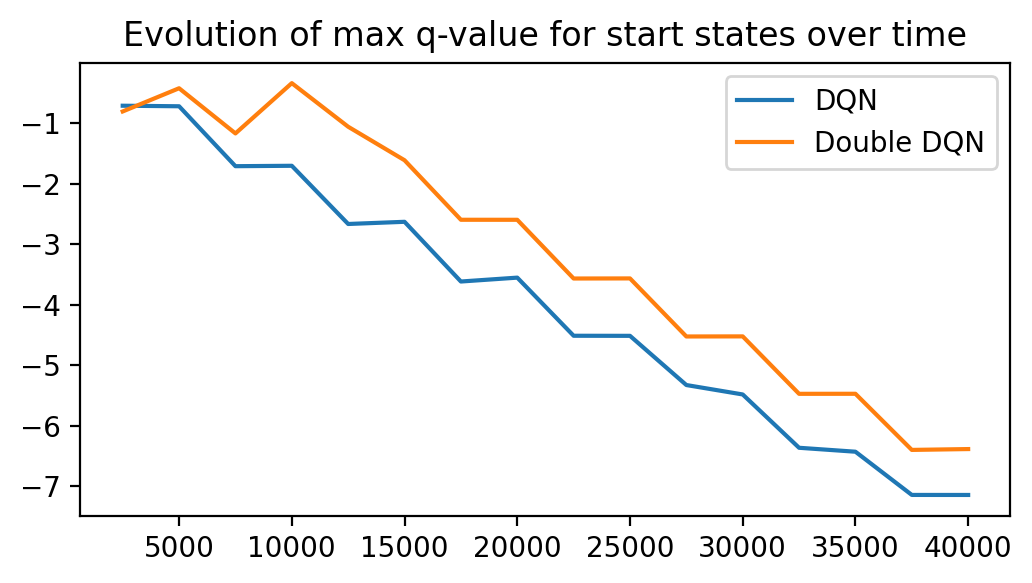

In [ ]:
plt.figure(figsize=(6, 3), dpi=200)
plt.title("Evolution of max q-value for start states over time")
plt.plot(monitor_dqn_value_cb.timesteps, monitor_dqn_value_cb.max_q_values, label="DQN")
plt.plot(monitor_double_q_value_cb.timesteps, monitor_double_q_value_cb.max_q_values, label="Double DQN")
plt.legend()